<a href="https://colab.research.google.com/github/fatsasabila/deeplearning_fatsa/blob/main/TaskWeek5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Fatsa Vidyaningtyas Sabila

NPM : 2306319445

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Working with Sequences
:label:`sec_sequence`

Up until now, we have focused on models whose inputs
consisted of a single feature vector $\mathbf{x} \in \mathbb{R}^d$.
The main change of perspective when developing models
capable of processing sequences is that we now
focus on inputs that consist of an ordered list
of feature vectors $\mathbf{x}_1, \dots, \mathbf{x}_T$,
where each feature vector $\mathbf{x}_t$ is
indexed by a time step $t \in \mathbb{Z}^+$
lying in $\mathbb{R}^d$.

Some datasets consist of a single massive sequence.
Consider, for example, the extremely long streams
of sensor readings that might be available to climate scientists.
In such cases, we might create training datasets
by randomly sampling subsequences of some predetermined length.
More often, our data arrives as a collection of sequences.
Consider the following examples:
(i) a collection of documents,
each represented as its own sequence of words,
and each having its own length $T_i$;
(ii) sequence representation of
patient stays in the hospital,
where each stay consists of a number of events
and the sequence length depends roughly
on the length of the stay.


Previously, when dealing with individual inputs,
we assumed that they were sampled independently
from the same underlying distribution $P(X)$.
While we still assume that entire sequences
(e.g., entire documents or patient trajectories)
are sampled independently,
we cannot assume that the data arriving
at each time step are independent of each other.
For example, the words that likely to appear later in a document
depend heavily on words occurring earlier in the document.
The medicine a patient is likely to receive
on the 10th day of a hospital visit
depends heavily on what transpired
in the previous nine days.

This should come as no surprise.
If we did not believe that the elements in a sequence were related,
we would not have bothered to model them as a sequence in the first place.
Consider the usefulness of the auto-fill features
that are popular on search tools and modern email clients.
They are useful precisely because it is often possible
to predict (imperfectly, but better than random guessing)
what the likely continuations of a sequence might be,
given some initial prefix.
For most sequence models,
we do not require independence,
or even stationarity, of our sequences.
Instead, we require only that
the sequences themselves are sampled
from some fixed underlying distribution
over entire sequences.

This flexible approach allows for such phenomena
as (i) documents looking significantly different
at the beginning than at the end;
or (ii) patient status evolving either
towards recovery or towards death
over the course of a hospital stay;
or (iii) customer taste evolving in predictable ways
over the course of continued interaction with a recommender system.


We sometimes wish to predict a fixed target $y$
given sequentially structured input
(e.g., sentiment classification based on a movie review).
At other times, we wish to predict a sequentially structured target
($y_1, \ldots, y_T$)
given a fixed input (e.g., image captioning).
Still other times, our goal is to predict sequentially structured targets
based on sequentially structured inputs
(e.g., machine translation or video captioning).
Such sequence-to-sequence tasks take two forms:
(i) *aligned*: where the input at each time step
aligns with a corresponding target (e.g., part of speech tagging);
(ii) *unaligned*: where the input and target
do not necessarily exhibit a step-for-step correspondence
(e.g., machine translation).

Before we worry about handling targets of any kind,
we can tackle the most straightforward problem:
unsupervised density modeling (also called *sequence modeling*).
Here, given a collection of sequences,
our goal is to estimate the probability mass function
that tells us how likely we are to see any given sequence,
i.e., $p(\mathbf{x}_1, \ldots, \mathbf{x}_T)$.


In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Autoregressive Models


Before introducing specialized neural networks
designed to handle sequentially structured data,
let's take a look at some actual sequence data
and build up some basic intuitions and statistical tools.
In particular, we will focus on stock price data
from the FTSE 100 index (:numref:`fig_ftse100`).
At each *time step* $t \in \mathbb{Z}^+$, we observe
the price, $x_t$, of the index at that time.


![FTSE 100 index over about 30 years.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/ftse100.png?raw=1)
:width:`400px`
:label:`fig_ftse100`


Now suppose that a trader would like to make short-term trades,
strategically getting into or out of the index,
depending on whether they believe
that it will rise or decline
in the subsequent time step.
Absent any other features
(news, financial reporting data, etc.),
the only available signal for predicting
the subsequent value is the history of prices to date.
The trader is thus interested in knowing
the probability distribution

$$P(x_t \mid x_{t-1}, \ldots, x_1)$$

over prices that the index might take
in the subsequent time step.
While estimating the entire distribution
over a continuously valued random variable
can be difficult, the trader would be happy
to focus on a few key statistics of the distribution,
particularly the expected value and the variance.
One simple strategy for estimating the conditional expectation

$$\mathbb{E}[(x_t \mid x_{t-1}, \ldots, x_1)],$$

would be to apply a linear regression model
(recall :numref:`sec_linear_regression`).
Such models that regress the value of a signal
on the previous values of that same signal
are naturally called *autoregressive models*.
There is just one major problem: the number of inputs,
$x_{t-1}, \ldots, x_1$ varies, depending on $t$.
In other words, the number of inputs increases
with the amount of data that we encounter.
Thus if we want to treat our historical data
as a training set, we are left with the problem
that each example has a different number of features.
Much of what follows in this chapter
will revolve around techniques
for overcoming these challenges
when engaging in such *autoregressive* modeling problems
where the object of interest is
$P(x_t \mid x_{t-1}, \ldots, x_1)$
or some statistic(s) of this distribution.

A few strategies recur frequently.
First of all,
we might believe that although long sequences
$x_{t-1}, \ldots, x_1$ are available,
it may not be necessary
to look back so far in the history
when predicting the near future.
In this case we might content ourselves
to condition on some window of length $\tau$
and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations.
The immediate benefit is that now the number of arguments
is always the same, at least for $t > \tau$.
This allows us to train any linear model or deep network
that requires fixed-length vectors as inputs.
Second, we might develop models that maintain
some summary $h_t$ of the past observations
(see :numref:`fig_sequence-model`)
and at the same time update $h_t$
in addition to the prediction $\hat{x}_t$.
This leads to models that estimate not only $x_t$
with $\hat{x}_t = P(x_t \mid h_{t})$
but also updates of the form
$h_t = g(h_{t-1}, x_{t-1})$.
Since $h_t$ is never observed,
these models are also called
*latent autoregressive models*.

![A latent autoregressive model.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/sequence-model.svg?raw=1)
:label:`fig_sequence-model`

To construct training data from historical data, one
typically creates examples by sampling windows randomly.
In general, we do not expect time to stand still.
However, we often assume that while
the specific values of $x_t$ might change,
the dynamics according to which each subsequent
observation is generated given the previous observations do not.
Statisticians call dynamics that do not change *stationary*.



## Sequence Models

Sometimes, especially when working with language,
we wish to estimate the joint probability
of an entire sequence.
This is a common task when working with sequences
composed of discrete *tokens*, such as words.
Generally, these estimated functions are called *sequence models*
and for natural language data, they are called *language models*.
The field of sequence modeling has been driven so much by natural language processing,
that we often describe sequence models as "language models",
even when dealing with non-language data.
Language models prove useful for all sorts of reasons.
Sometimes we want to evaluate the likelihood of sentences.
For example, we might wish to compare
the naturalness of two candidate outputs
generated by a machine translation system
or by a speech recognition system.
But language modeling gives us not only
the capacity to *evaluate* likelihood,
but the ability to *sample* sequences,
and even to optimize for the most likely sequences.

While language modeling might not, at first glance, look
like an autoregressive problem,
we can reduce language modeling to autoregressive prediction
by decomposing the joint density  of a sequence $p(x_1, \ldots, x_T)$
into the product of conditional densities
in a left-to-right fashion
by applying the chain rule of probability:

$$P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

Note that if we are working with discrete signals such as words,
then the autoregressive model must be a probabilistic classifier,
outputting a full probability distribution
over the vocabulary for whatever word will come next,
given the leftwards context.



### Markov Models
:label:`subsec_markov-models`


Now suppose that we wish to employ the strategy mentioned above,
where we condition only on the $\tau$ previous time steps,
i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than
the entire sequence history $x_{t-1}, \ldots, x_1$.
Whenever we can throw away the history
beyond the previous $\tau$ steps
without any loss in predictive power,
we say that the sequence satisfies a *Markov condition*,
i.e., *that the future is conditionally independent of the past,
given the recent history*.
When $\tau = 1$, we say that the data is characterized
by a *first-order Markov model*,
and when $\tau = k$, we say that the data is characterized
by a $k^{\textrm{th}}$-order Markov model.
For when the first-order Markov condition holds ($\tau = 1$)
the factorization of our joint probability becomes a product
of probabilities of each word given the previous *word*:

$$P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^T P(x_t \mid x_{t-1}).$$

We often find it useful to work with models that proceed
as though a Markov condition were satisfied,
even when we know that this is only *approximately* true.
With real text documents we continue to gain information
as we include more and more leftwards context.
But these gains diminish rapidly.
Thus, sometimes we compromise, obviating computational and statistical difficulties
by training models whose validity depends
on a $k^{\textrm{th}}$-order Markov condition.
Even today's massive RNN- and Transformer-based language models
seldom incorporate more than thousands of words of context.


With discrete data, a true Markov model
simply counts the number of times
that each word has occurred in each context, producing
the relative frequency estimate of $P(x_t \mid x_{t-1})$.
Whenever the data assumes only discrete values
(as in language),
the most likely sequence of words can be computed efficiently
using dynamic programming.


### The Order of Decoding

You may be wondering why we represented
the factorization of a text sequence $P(x_1, \ldots, x_T)$
as a left-to-right chain of conditional probabilities.
Why not right-to-left or some other, seemingly random order?
In principle, there is nothing wrong with unfolding
$P(x_1, \ldots, x_T)$ in reverse order.
The result is a valid factorization:

$$P(x_1, \ldots, x_T) = P(x_T) \prod_{t=T-1}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$


However, there are many reasons why factorizing text
in the same direction in which we read it
(left-to-right for most languages,
but right-to-left for Arabic and Hebrew)
is preferred for the task of language modeling.
First, this is just a more natural direction for us to think about.
After all we all read text every day,
and this process is guided by our ability
to anticipate which words and phrases
are likely to come next.
Just think of how many times you have completed
someone else's sentence.
Thus, even if we had no other reason to prefer such in-order decodings,
they would be useful if only because we have better intuitions
for what should be likely when predicting in this order.

Second, by factorizing in order,
we can assign probabilities to arbitrarily long sequences
using the same language model.
To convert a probability over steps $1$ through $t$
into one that extends to word $t+1$ we simply
multiply by the conditional probability
of the additional token given the previous ones:
$P(x_{t+1}, \ldots, x_1) = P(x_{t}, \ldots, x_1) \cdot P(x_{t+1} \mid x_{t}, \ldots, x_1)$.

Third, we have stronger predictive models
for predicting adjacent words than
words at arbitrary other locations.
While all orders of factorization are valid,
they do not necessarily all represent equally easy
predictive modeling problems.
This is true not only for language,
but for other kinds of data as well,
e.g., when the data is causally structured.
For example, we believe that future events cannot influence the past.
Hence, if we change $x_t$, we may be able to influence
what happens for $x_{t+1}$ going forward but not the converse.
That is, if we change $x_t$, the distribution over past events will not change.
In some contexts, this makes it easier to predict $P(x_{t+1} \mid x_t)$
than to predict $P(x_t \mid x_{t+1})$.
For instance, in some cases, we can find $x_{t+1} = f(x_t) + \epsilon$
for some additive noise $\epsilon$,
whereas the converse is not true :cite:`Hoyer.Janzing.Mooij.ea.2009`.
This is great news, since it is typically the forward direction
that we are interested in estimating.
The book by :citet:`Peters.Janzing.Scholkopf.2017` contains more on this topic.
We barely scratch the surface of it.


## Training

Before we focus our attention on text data,
let's first try this out with some
continuous-valued synthetic data.

(**Here, our 1000 synthetic data will follow
the trigonometric `sin` function,
applied to 0.01 times the time step.
To make the problem a little more interesting,
we corrupt each sample with additive noise.**)
From this sequence we extract training examples,
each consisting of features and a label.


In [ ]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

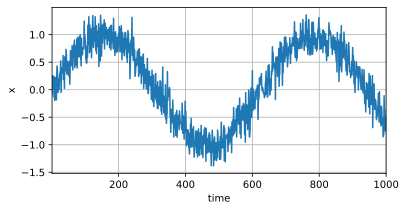

In [ ]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

To begin, we try a model that acts as if
the data satisfied a $\tau^{\textrm{th}}$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations.
[**Thus for each time step we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]
The astute reader might have noticed that
this results in $1000-\tau$ examples,
since we lack sufficient history for $y_1, \ldots, y_\tau$.
While we could pad the first $\tau$ sequences with zeros,
to keep things simple, we drop them for now.
The resulting dataset contains $T - \tau$ examples,
where each input to the model has sequence length $\tau$.
We (**create a data iterator on the first 600 examples**),
covering a period of the sin function.


In [ ]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a standard linear regression.


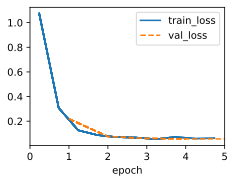

In [ ]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

## Prediction

[**To evaluate our model, we first check
how well it performs at one-step-ahead prediction**].


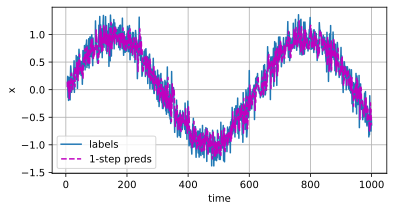

In [ ]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

These predictions look good,
even near the end at $t=1000$.

But what if we only observed sequence data
up until time step 604 (`n_train + tau`)
and wished to make predictions several steps
into the future?
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired time step:

$$\begin{aligned}
\hat{x}_{605} &= f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} &= f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} &= f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} &= f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} &= f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
&\vdots\end{aligned}$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [ ]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

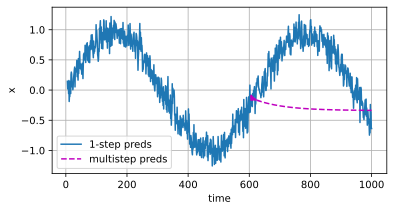

In [ ]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this is down to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [ ]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

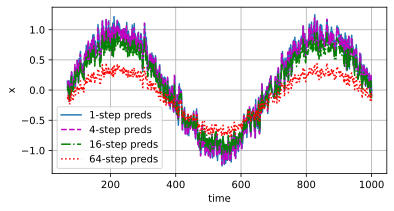

In [ ]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is almost useless.

## Summary

There is quite a difference in difficulty
between interpolation and extrapolation.
Consequently, if you have a sequence, always respect
the temporal order of the data when training,
i.e., never train on future data.
Given this kind of data,
sequence models require specialized statistical tools for estimation.
Two popular choices are autoregressive models
and latent-variable autoregressive models.
For causal models (e.g., time going forward),
estimating the forward direction is typically
a lot easier than the reverse direction.
For an observed sequence up to time step $t$,
its predicted output at time step $t+k$
is the $k$*-step-ahead prediction*.
As we predict further in time by increasing $k$,
the errors accumulate and the quality of the prediction degrades,
often dramatically.

## Exercises

1. Improve the model in the experiment of this section.
    1. Incorporate more than the past four observations? How many do you really need?
    1. How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    1. Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?
    1. Change the neural network architecture and evaluate the performance. You may train the new model with more epochs. What do you observe?
1. An investor wants to find a good security to buy.
   They look at past returns to decide which one is likely to do well.
   What could possibly go wrong with this strategy?
1. Does causality also apply to text? To which extent?
1. Give an example for when a latent autoregressive model
   might be needed to capture the dynamic of the data.


Answer:
1. Incorporating more than four past observations may improve the model, especially in capturing longer-term dependencies. However, the optimal number of past observations depends on the data's underlying structure. If there were no noise, a perfect model of a periodic function like sine or cosine could require just two past observations due to their second-order differential equation representation. Including older observations while keeping the total feature count constant could involve downsampling or compressing data, but this might not always improve accuracy. Neural network architecture changes, such as adding layers or increasing units, might capture more complex relationships, but after a certain point, increasing model complexity can lead to diminishing returns or overfitting, depending on the amount of training data and the noise level.

2. Relying solely on past returns to predict future performance can lead to poor decisions. This strategy assumes that past trends will continue, ignoring market volatility and external factors that can affect security prices. Historical performance may also reflect temporary trends or noise, not necessarily future potential. Thus, investors may overlook fundamental changes in the company or market that could invalidate past patterns.

3. Causality does apply to text to some extent, especially in narrative structures where one event leads to another. However, textual data is often more ambiguous and nonlinear compared to time series data, making causality harder to define clearly. Contextual relationships between words or sentences may appear causal but often reflect correlation or association instead, depending on the structure and style of the text.

4. A latent autoregressive model might be needed when modeling financial time series data where hidden variables influence the observed returns. For example, stock prices could be driven by latent factors such as investor sentiment, which cannot be directly observed but impact market behavior over time. In such cases, an autoregressive model that accounts for these hidden dynamics can better capture the underlying patterns of the data.

9.2

In [ ]:
!pip install d2l==1.0.3


# Converting Raw Text into Sequence Data
:label:`sec_text-sequence`

Throughout this book,
we will often work with text data
represented as sequences
of words, characters, or word pieces.
To get going, we will need some basic
tools for converting raw text
into sequences of the appropriate form.
Typical preprocessing pipelines
execute the following steps:

1. Load text as strings into memory.
1. Split the strings into tokens (e.g., words or characters).
1. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.
1. Convert the text into sequences of numerical indices.


In [ ]:
import collections
import random
import re
import torch
from d2l import torch as d2l

## Reading the Dataset

Here, we will work with H. G. Wells'
[The Time Machine](http://www.gutenberg.org/ebooks/35),
a book containing just over 30,000 words.
While real applications will typically
involve significantly larger datasets,
this is sufficient to demonstrate
the preprocessing pipeline.
The following `_download` method
(**reads the raw text into a string**).


In [ ]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

[Discussions](https://discuss.d2l.ai/t/114)


For simplicity, we ignore punctuation and capitalization when preprocessing the raw text.


In [ ]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization

*Tokens* are the atomic (indivisible) units of text.
Each time step corresponds to 1 token,
but what precisely constitutes a token is a design choice.
For example, we could represent the sentence
"Baby needs a new pair of shoes"
as a sequence of 7 words,
where the set of all words comprise
a large vocabulary (typically tens
or hundreds of thousands of words).
Or we would represent the same sentence
as a much longer sequence of 30 characters,
using a much smaller vocabulary
(there are only 256 distinct ASCII characters).
Below, we tokenize our preprocessed text
into a sequence of characters.


In [ ]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary

These tokens are still strings.
However, the inputs to our models
must ultimately consist
of numerical inputs.
[**Next, we introduce a class
for constructing *vocabularies*,
i.e., objects that associate
each distinct token value
with a unique index.**]
First, we determine the set of unique tokens in our training *corpus*.
We then assign a numerical index to each unique token.
Rare vocabulary elements are often dropped for convenience.
Whenever we encounter a token at training or test time
that had not been previously seen or was dropped from the vocabulary,
we represent it by a special "&lt;unk&gt;" token,
signifying that this is an *unknown* value.


In [ ]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

We now [**construct a vocabulary**] for our dataset,
converting the sequence of strings
into a list of numerical indices.
Note that we have not lost any information
and can easily convert our dataset
back to its original (string) representation.


In [ ]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## Putting It All Together

Using the above classes and methods,
we [**package everything into the following
`build` method of the `TimeMachine` class**],
which returns `corpus`, a list of token indices, and `vocab`,
the vocabulary of *The Time Machine* corpus.
The modifications we did here are:
(i) we tokenize text into characters, not words,
to simplify the training in later sections;
(ii) `corpus` is a single list, not a list of token lists,
since each text line in *The Time Machine* dataset
is not necessarily a sentence or paragraph.


In [ ]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

## Exploratory Language Statistics
:label:`subsec_natural-lang-stat`

Using the real corpus and the `Vocab` class defined over words,
we can inspect basic statistics concerning word use in our corpus.
Below, we construct a vocabulary from words used in *The Time Machine*
and print the ten most frequently occurring of them.


In [ ]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Note that (**the ten most frequent words**)
are not all that descriptive.
You might even imagine that
we might see a very similar list
if we had chosen any book at random.
Articles like "the" and "a",
pronouns like "i" and "my",
and prepositions like "of", "to", and "in"
occur often because they serve common syntactic roles.
Such words that are common but not particularly descriptive
are often called (***stop words***) and,
in previous generations of text classifiers
based on so-called bag-of-words representations,
they were most often filtered out.
However, they carry meaning and
it is not necessary to filter them out
when working with modern RNN- and
Transformer-based neural models.
If you look further down the list,
you will notice
that word frequency decays quickly.
The $10^{\textrm{th}}$ most frequent word
is less than $1/5$ as common as the most popular.
Word frequency tends to follow a power law distribution
(specifically the Zipfian) as we go down the ranks.
To get a better idea, we [**plot the figure of the word frequency**].


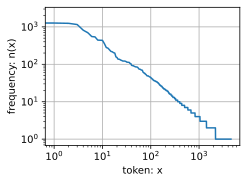

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

After dealing with the first few words as exceptions,
all the remaining words roughly follow a straight line on a log--log plot.
This phenomenon is captured by *Zipf's law*,
which states that the frequency $n_i$
of the $i^\textrm{th}$ most frequent word is:

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

which is equivalent to

$$\log n_i = -\alpha \log i + c,$$

where $\alpha$ is the exponent that characterizes
the distribution and $c$ is a constant.
This should already give us pause for thought if we want
to model words by counting statistics.
After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But [**what about the other word combinations, such as two consecutive words (bigrams), three consecutive words (trigrams)**], and beyond?
Let's see whether the bigram frequency behaves in the same manner as the single word (unigram) frequency.


In [ ]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book---"the time". Furthermore, let's see whether the trigram frequency behaves in the same manner.


In [ ]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

Now, let's [**visualize the token frequency**] among these three models: unigrams, bigrams, and trigrams.


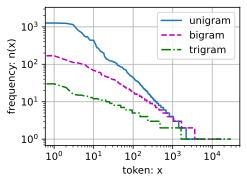

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

This figure is quite exciting.
First, beyond unigram words, sequences of words
also appear to be following Zipf's law,
albeit with a smaller exponent
$\alpha$ in :eqref:`eq_zipf_law`,
depending on the sequence length.
Second, the number of distinct $n$-grams is not that large.
This gives us hope that there is quite a lot of structure in language.
Third, many $n$-grams occur very rarely.
This makes certain methods unsuitable for language modeling
and motivates the use of deep learning models.
We will discuss this in the next section.


## Summary

Text is among the most common forms of sequence data encountered in deep learning.
Common choices for what constitutes a token are characters, words, and word pieces.
To preprocess text, we usually (i) split text into tokens; (ii) build a vocabulary to map token strings to numerical indices; and (iii) convert text data into token indices for models to manipulate.
In practice, the frequency of words tends to follow Zipf's law. This is true not just for individual words (unigrams), but also for $n$-grams.


## Exercises

1. In the experiment of this section, tokenize text into words and vary the `min_freq` argument value of the `Vocab` instance. Qualitatively characterize how changes in `min_freq` impact the size of the resulting vocabulary.
1. Estimate the exponent of Zipfian distribution for unigrams, bigrams, and trigrams in this corpus.
1. Find some other sources of data (download a standard machine learning dataset, pick another public domain book,
   scrape a website, etc). For each, tokenize the data at both the word and character levels. How do the vocabulary sizes compare with *The Time Machine* corpus at equivalent values of `min_freq`. Estimate the exponent of the Zipfian distribution corresponding to the unigram and bigram distributions for these corpora. How do they compare with the values that you observed for *The Time Machine* corpus?


Answer:
1. Varying the `min_freq` argument in the `Vocab` instance directly affects the size of the vocabulary. A lower `min_freq` value includes more rare words in the vocabulary, increasing its size, but it may also introduce noise or infrequent words that don't contribute much to model performance. As `min_freq` increases, the vocabulary becomes smaller and focuses on more frequent words, potentially improving generalization but at the cost of ignoring less common but possibly important words. The key is finding a balance where the vocabulary is neither too large (overfitting) nor too small (underfitting).

2. To estimate the exponent of the Zipfian distribution for unigrams, bigrams, and trigrams, you can plot the rank-frequency distribution on a log-log scale. The slope of the line approximates the exponent. For unigrams, the exponent tends to follow Zipf's law more closely, often around -1. For bigrams and trigrams, the distribution becomes flatter, and the exponent decreases, reflecting the reduced frequency of longer sequences. The exponent's magnitude decreases as the n-gram size increases, showing less steep decay in frequency as we move to bigrams and trigrams.

3. When tokenizing new datasets at both the word and character levels, the vocabulary size typically grows faster at the word level, especially for larger corpora or those with diverse language use. At equivalent values of `min_freq`, a more diverse dataset or a public domain book might yield a larger vocabulary compared to *The Time Machine*, depending on the genre or style. For instance, websites with technical or domain-specific language may have larger vocabularies due to jargon. When estimating the Zipfian exponent for these corpora, unigrams from a highly specialized dataset might exhibit a steeper slope (higher exponent) due to the presence of rare terms, while bigrams and trigrams would likely show a flatter slope as sequences become more common. This behavior might deviate from what was observed in *The Time Machine*, especially for corpora with structured or repetitive text like technical manuals.


9.3

In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.0 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Unin

# Language Models
:label:`sec_language-model`

In :numref:`sec_text-sequence`, we saw how to map text sequences into tokens, where these tokens can be viewed as a sequence of discrete observations such as words or characters. Assume that the tokens in a text sequence of length $T$ are in turn $x_1, x_2, \ldots, x_T$.
The goal of *language models*
is to estimate the joint probability of the whole sequence:

$$P(x_1, x_2, \ldots, x_T),$$

where statistical tools
in :numref:`sec_sequence`
can be applied.

Language models are incredibly useful. For instance, an ideal language model should generate natural text on its own, simply by drawing one token at a time $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$.
Quite unlike the monkey using a typewriter, all text emerging from such a model would pass as natural language, e.g., English text. Furthermore, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments.
Clearly we are still very far from designing such a system, since it would need to *understand* the text rather than just generate grammatically sensible content.

Nonetheless, language models are of great service even in their limited form.
For instance, the phrases "to recognize speech" and "to wreck a nice beach" sound very similar.
This can cause ambiguity in speech recognition,
which is easily resolved through a language model that rejects the second translation as outlandish.
Likewise, in a document summarization algorithm
it is worthwhile knowing that "dog bites man" is much more frequent than "man bites dog", or that "I want to eat grandma" is a rather disturbing statement, whereas "I want to eat, grandma" is much more benign.


In [1]:
import torch
from d2l import torch as d2l

## Learning Language Models

The obvious question is how we should model a document, or even a sequence of tokens.
Suppose that we tokenize text data at the word level.
Let's start by applying basic probability rules:

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

For example,
the probability of a text sequence containing four words would be given as:

$$\begin{aligned}&P(\textrm{deep}, \textrm{learning}, \textrm{is}, \textrm{fun}) \\
=&P(\textrm{deep}) P(\textrm{learning}  \mid  \textrm{deep}) P(\textrm{is}  \mid  \textrm{deep}, \textrm{learning}) P(\textrm{fun}  \mid  \textrm{deep}, \textrm{learning}, \textrm{is}).\end{aligned}$$

### Markov Models and $n$-grams
:label:`subsec_markov-models-and-n-grams`

Among those sequence model analyses in :numref:`sec_sequence`,
let's apply Markov models to language modeling.
A distribution over sequences satisfies the Markov property of first order if $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

The probability formulae that involve one, two, and three variables are typically referred to as *unigram*, *bigram*, and *trigram* models, respectively.
In order to compute the language model, we need to calculate the
probability of words and the conditional probability of a word given
the previous few words.
Note that
such probabilities are
language model parameters.



### Word Frequency

Here, we
assume that the training dataset is a large text corpus, such as all
Wikipedia entries, [Project Gutenberg](https://en.wikipedia.org/wiki/Project_Gutenberg),
and all text posted on the
web.
The probability of words can be calculated from the relative word
frequency of a given word in the training dataset.
For example, the estimate $\hat{P}(\textrm{deep})$ can be calculated as the
probability of any sentence starting with the word "deep". A
slightly less accurate approach would be to count all occurrences of
the word "deep" and divide it by the total number of words in
the corpus.
This works fairly well, particularly for frequent
words. Moving on, we could attempt to estimate

$$\hat{P}(\textrm{learning} \mid \textrm{deep}) = \frac{n(\textrm{deep, learning})}{n(\textrm{deep})},$$

where $n(x)$ and $n(x, x')$ are the number of occurrences of singletons
and consecutive word pairs, respectively.
Unfortunately,
estimating the
probability of a word pair is somewhat more difficult, since the
occurrences of "deep learning" are a lot less frequent.
In particular, for some unusual word combinations it may be tricky to
find enough occurrences to get accurate estimates.
As suggested by the empirical results in :numref:`subsec_natural-lang-stat`,
things take a turn for the worse for three-word combinations and beyond.
There will be many plausible three-word combinations that we likely will not see in our dataset.
Unless we provide some solution to assign such word combinations a nonzero count, we will not be able to use them in a language model. If the dataset is small or if the words are very rare, we might not find even a single one of them.

### Laplace Smoothing

A common strategy is to perform some form of *Laplace smoothing*.
The solution is to
add a small constant to all counts.
Denote by $n$ the total number of words in
the training set
and $m$ the number of unique words.
This solution helps with singletons, e.g., via

$$\begin{aligned}
	\hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
	\hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}$$

Here $\epsilon_1,\epsilon_2$, and $\epsilon_3$ are hyperparameters.
Take $\epsilon_1$ as an example:
when $\epsilon_1 = 0$, no smoothing is applied;
when $\epsilon_1$ approaches positive infinity,
$\hat{P}(x)$ approaches the uniform probability $1/m$.
The above is a rather primitive variant of what
other techniques can accomplish :cite:`Wood.Gasthaus.Archambeau.ea.2011`.


Unfortunately, models like this get unwieldy rather quickly
for the following reasons.
First,
as discussed in :numref:`subsec_natural-lang-stat`,
many $n$-grams occur very rarely,
making Laplace smoothing rather unsuitable for language modeling.
Second, we need to store all counts.
Third, this entirely ignores the meaning of the words. For
instance, "cat" and "feline" should occur in related contexts.
It is quite difficult to adjust such models to additional contexts,
whereas, deep learning based language models are well suited to
take this into account.
Last, long word
sequences are almost certain to be novel, hence a model that simply
counts the frequency of previously seen word sequences is bound to perform poorly there.
Therefore, we focus on using neural networks for language modeling
in the rest of the chapter.


## Perplexity
:label:`subsec_perplexity`

Next, let's discuss about how to measure the quality of the language model, which we will then use to evaluate our models in the subsequent sections.
One way is to check how surprising the text is.
A good language model is able to predict, with high accuracy, the tokens that come next.
Consider the following continuations of the phrase "It is raining", as proposed by different language models:

1. "It is raining outside"
1. "It is raining banana tree"
1. "It is raining piouw;kcj pwepoiut"

In terms of quality, Example 1 is clearly the best. The words are sensible and logically coherent.
While it might not quite accurately reflect which word follows semantically ("in San Francisco" and "in winter" would have been perfectly reasonable extensions), the model is able to capture which kind of word follows.
Example 2 is considerably worse by producing a nonsensical extension. Nonetheless, at least the model has learned how to spell words and some degree of correlation between words. Last, Example 3 indicates a poorly trained model that does not fit data properly.

We might measure the quality of the model by computing  the likelihood of the sequence.
Unfortunately this is a number that is hard to understand and difficult to compare.
After all, shorter sequences are much more likely to occur than the longer ones,
hence evaluating the model on Tolstoy's magnum opus
*War and Peace* will inevitably produce a much smaller likelihood than, say, on Saint-Exupery's novella *The Little Prince*. What is missing is the equivalent of an average.

Information theory comes handy here.
We defined entropy, surprisal, and cross-entropy
when we introduced the softmax regression
(:numref:`subsec_info_theory_basics`).
If we want to compress text, we can ask about
predicting the next token given the current set of tokens.
A better language model should allow us to predict the next token more accurately.
Thus, it should allow us to spend fewer bits in compressing the sequence.
So we can measure it by the cross-entropy loss averaged
over all the $n$ tokens of a sequence:

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
:eqlabel:`eq_avg_ce_for_lm`

where $P$ is given by a language model and $x_t$ is the actual token observed at time step $t$ from the sequence.
This makes the performance on documents of different lengths comparable. For historical reasons, scientists in natural language processing prefer to use a quantity called *perplexity*. In a nutshell, it is the exponential of :eqref:`eq_avg_ce_for_lm`:

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

Perplexity can be best understood as the reciprocal of the geometric mean of the number of real choices that we have when deciding which token to pick next. Let's look at a number of cases:

* In the best case scenario, the model always perfectly estimates the probability of the target token as 1. In this case the perplexity of the model is 1.
* In the worst case scenario, the model always predicts the probability of the target token as 0. In this situation, the perplexity is positive infinity.
* At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary. In fact, if we were to store the sequence without any compression, this would be the best we could do for encoding it. Hence, this provides a nontrivial upper bound that any useful model must beat.

## Partitioning Sequences
:label:`subsec_partitioning-seqs`

We will design language models using neural networks
and use perplexity to evaluate
how good the model is at
predicting the next token given the current set of tokens
in text sequences.
Before introducing the model,
let's assume that it
processes a minibatch of sequences with predefined length
at a time.
Now the question is how to [**read minibatches of input sequences and target sequences at random**].


Suppose that the dataset takes the form of a sequence of $T$ token indices in `corpus`.
We will
partition it
into subsequences, where each subsequence has $n$ tokens (time steps).
To iterate over
(almost) all the tokens of the entire dataset
for each epoch
and obtain all possible length-$n$ subsequences,
we can introduce randomness.
More concretely,
at the beginning of each epoch,
discard the first $d$ tokens,
where $d\in [0,n)$ is uniformly sampled at random.
The rest of the sequence
is then partitioned
into $m=\lfloor (T-d)/n \rfloor$ subsequences.
Denote by $\mathbf x_t = [x_t, \ldots, x_{t+n-1}]$ the length-$n$ subsequence starting from token $x_t$ at time step $t$.
The resulting $m$ partitioned subsequences
are
$\mathbf x_d, \mathbf x_{d+n}, \ldots, \mathbf x_{d+n(m-1)}.$
Each subsequence will be used as an input sequence into the language model.


For language modeling,
the goal is to predict the next token based on the tokens we have seen so far; hence the targets (labels) are the original sequence, shifted by one token.
The target sequence for any input sequence $\mathbf x_t$
is $\mathbf x_{t+1}$ with length $n$.

![Obtaining five pairs of input sequences and target sequences from partitioned length-5 subsequences.](../img/lang-model-data.svg)
:label:`fig_lang_model_data`

:numref:`fig_lang_model_data` shows an example of obtaining five pairs of input sequences and target sequences with $n=5$ and $d=2$.


In [2]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

To train language models,
we will randomly sample
pairs of input sequences and target sequences
in minibatches.
The following data loader randomly generates a minibatch from the dataset each time.
The argument `batch_size` specifies the number of subsequence examples in each minibatch
and `num_steps` is the subsequence length in tokens.


In [3]:
@d2l.add_to_class(d2l.TimeMachine)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

As we can see in the following,
a minibatch of target sequences
can be obtained
by shifting the input sequences
by one token.


In [4]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 6,  0, 21, 16,  0,  4, 16, 15, 21, 19],
        [21,  9,  2, 15,  0,  2,  0, 20, 14,  2]]) 
Y: tensor([[ 0, 21, 16,  0,  4, 16, 15, 21, 19, 16],
        [ 9,  2, 15,  0,  2,  0, 20, 14,  2, 13]])


## Summary and Discussion

Language models estimate the joint probability of a text sequence. For long sequences, $n$-grams provide a convenient model by truncating the dependence. However, there is a lot of structure but not enough frequency to deal efficiently with infrequent word combinations via Laplace smoothing. Thus, we will focus on neural language modeling in subsequent sections.
To train language models, we can randomly sample pairs of input sequences and target sequences in minibatches. After training, we will use perplexity to measure the language model quality.

Language models can be scaled up with increased data size, model size, and amount in training compute. Large language models can perform desired tasks by predicting output text given input text instructions. As we will discuss later (e.g., :numref:`sec_large-pretraining-transformers`),
at the present moment
large language models form the basis of state-of-the-art systems across diverse tasks.


## Exercises

1. Suppose there are 100,000 words in the training dataset. How much word frequency and multi-word adjacent frequency does a four-gram need to store?
1. How would you model a dialogue?
1. What other methods can you think of for reading long sequence data?
1. Consider our method for discarding a uniformly random number of the first few tokens at the beginning of each epoch.
    1. Does it really lead to a perfectly uniform distribution over the sequences on the document?
    1. What would you have to do to make things even more uniform?
1. If we want a sequence example to be a complete sentence, what kind of problem does this introduce in minibatch sampling? How can we fix it?


1. In a four-gram model, we need to store both word frequency and adjacent word (multi-word) frequency information. With 100,000 unique words in the training dataset, the total number of possible four-grams is \( 100,000^4 \), but most combinations will not appear. We would only store frequencies for the n-grams that actually occur in the data, which is much smaller but still substantial in size, particularly for larger corpora.

2. To model a dialogue, we can use sequence-to-sequence (Seq2Seq) models, possibly enhanced with attention mechanisms or transformers. These models allow us to capture the sequential nature of conversations while considering context across multiple dialogue turns. A hierarchical approach, such as hierarchical recurrent neural networks (HRNN), could help maintain coherence by processing dialogue as a sequence of utterances rather than treating it as a single monolithic sequence.

3. When working with long sequence data, recurrent models like LSTMs or GRUs are effective, but transformers are gaining popularity for capturing long-range dependencies. Additionally, hierarchical models can break long sequences into smaller chunks and then combine their outputs. Sliding window approaches or dilated convolutions can help manage different parts of a sequence, allowing us to focus on varying scales of the input data.

4. Discarding a random number of tokens at the start of each sequence may not create a perfectly uniform distribution across the document. Certain portions of the text might get underrepresented. To achieve a more uniform distribution, we could use stratified sampling or dynamically adjust starting points in each epoch to ensure all tokens and sections are equally represented. This would improve uniformity in the data.

5. Sampling complete sentences introduces varying sequence lengths, which complicates minibatch processing since models usually expect uniform sequence lengths. We can use padding, but this leads to inefficiency. To address this, we could group sentences of similar lengths into batches (bucketed sampling) or adjust batch sizes dynamically based on sentence length. Alternatively, using architectures that naturally handle variable-length sequences, such as attention-based models, would help alleviate this issue.

9.4

# Recurrent Neural Networks
:label:`sec_rnn`


In :numref:`sec_language-model` we described Markov models and $n$-grams for language modeling, where the conditional probability of token $x_t$ at time step $t$ only depends on the $n-1$ previous tokens.
If we want to incorporate the possible effect of tokens earlier than time step $t-(n-1)$ on $x_t$,
we need to increase $n$.
However, the number of model parameters would also increase exponentially with it, as we need to store $|\mathcal{V}|^n$ numbers for a vocabulary set $\mathcal{V}$.
Hence, rather than modeling $P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$ it is preferable to use a latent variable model,

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

where $h_{t-1}$ is a *hidden state*  that stores the sequence information up to time step $t-1$.
In general,
the hidden state at any time step $t$ could be computed based on both the current input $x_{t}$ and the previous hidden state $h_{t-1}$:

$$h_t = f(x_{t}, h_{t-1}).$$
:eqlabel:`eq_ht_xt`

For a sufficiently powerful function $f$ in :eqref:`eq_ht_xt`, the latent variable model is not an approximation. After all, $h_t$ may simply store all the data it has observed so far.
However, it could potentially make both computation and storage expensive.

Recall that we have discussed hidden layers with hidden units in :numref:`chap_perceptrons`.
It is noteworthy that
hidden layers and hidden states refer to two very different concepts.
Hidden layers are, as explained, layers that are hidden from view on the path from input to output.
Hidden states are technically speaking *inputs* to whatever we do at a given step,
and they can only be computed by looking at data at previous time steps.

*Recurrent neural networks* (RNNs) are neural networks with hidden states. Before introducing the RNN model, we first revisit the MLP model introduced in :numref:`sec_mlp`.


In [5]:
import torch
from d2l import torch as d2l

## Neural Networks without Hidden States

Let's take a look at an MLP with a single hidden layer.
Let the hidden layer's activation function be $\phi$.
Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{\textrm{xh}} + \mathbf{b}_\textrm{h}).$$
:eqlabel:`rnn_h_without_state`

In :eqref:`rnn_h_without_state`, we have the weight parameter $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}$, the bias parameter $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$, and the number of hidden units $h$, for the hidden layer.
So armed, we apply broadcasting (see :numref:`subsec_broadcasting`) during the summation.
Next, the hidden layer output $\mathbf{H}$ is used as input of the output layer, which is given by

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q},$$

where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer.  If it is a classification problem, we can use $\mathrm{softmax}(\mathbf{O})$ to compute the probability distribution of the output categories.

This is entirely analogous to the regression problem we solved previously in :numref:`sec_sequence`, hence we omit details.
Suffice it to say that we can pick feature-label pairs at random and learn the parameters of our network via automatic differentiation and stochastic gradient descent.

## Recurrent Neural Networks with Hidden States
:label:`subsec_rnn_w_hidden_states`

Matters are entirely different when we have hidden states. Let's look at the structure in some more detail.

Assume that we have
a minibatch of inputs
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
at time step $t$.
In other words,
for a minibatch of $n$ sequence examples,
each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence.
Next,
denote by $\mathbf{H}_t  \in \mathbb{R}^{n \times h}$ the hidden layer output of time step $t$.
Unlike with MLP, here we save the hidden layer output $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden layer output of the previous time step in the current time step. Specifically, the calculation of the hidden layer output of the current time step is determined by the input of the current time step together with the hidden layer output of the previous time step:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h}).$$
:eqlabel:`rnn_h_with_state`

Compared with :eqref:`rnn_h_without_state`, :eqref:`rnn_h_with_state` adds one more term $\mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$ and thus
instantiates :eqref:`eq_ht_xt`.
From the relationship between hidden layer outputs $\mathbf{H}_t$ and $\mathbf{H}_{t-1}$ of adjacent time steps,
we know that these variables captured and retained the sequence's historical information up to their current time step, just like the state or memory of the neural network's current time step. Therefore, such a hidden layer output is called a *hidden state*.
Since the hidden state uses the same definition of the previous time step in the current time step, the computation of :eqref:`rnn_h_with_state` is *recurrent*. Hence, as we said, neural networks with hidden states
based on recurrent computation are named
*recurrent neural networks*.
Layers that perform
the computation of :eqref:`rnn_h_with_state`
in RNNs
are called *recurrent layers*.


There are many different ways for constructing RNNs.
Those with a hidden state defined by :eqref:`rnn_h_with_state` are very common.
For time step $t$,
the output of the output layer is similar to the computation in the MLP:

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}.$$

Parameters of the RNN
include the weights $\mathbf{W}_{\textrm{xh}} \in \mathbb{R}^{d \times h}, \mathbf{W}_{\textrm{hh}} \in \mathbb{R}^{h \times h}$,
and the bias $\mathbf{b}_\textrm{h} \in \mathbb{R}^{1 \times h}$
of the hidden layer,
together with the weights $\mathbf{W}_{\textrm{hq}} \in \mathbb{R}^{h \times q}$
and the bias $\mathbf{b}_\textrm{q} \in \mathbb{R}^{1 \times q}$
of the output layer.
It is worth mentioning that
even at different time steps,
RNNs always use these model parameters.
Therefore, the parametrization cost of an RNN
does not grow as the number of time steps increases.

:numref:`fig_rnn` illustrates the computational logic of an RNN at three adjacent time steps.
At any time step $t$,
the computation of the hidden state can be treated as:
(i) concatenating the input $\mathbf{X}_t$ at the current time step $t$ and the hidden state $\mathbf{H}_{t-1}$ at the previous time step $t-1$;
(ii) feeding the concatenation result into a fully connected layer with the activation function $\phi$.
The output of such a fully connected layer is the hidden state $\mathbf{H}_t$ of the current time step $t$.
In this case,
the model parameters are the concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$, and a bias of $\mathbf{b}_\textrm{h}$, all from :eqref:`rnn_h_with_state`.
The hidden state of the current time step $t$, $\mathbf{H}_t$, will participate in computing the hidden state $\mathbf{H}_{t+1}$ of the next time step $t+1$.
What is more, $\mathbf{H}_t$ will also be
fed into the fully connected output layer
to compute the output
$\mathbf{O}_t$ of the current time step $t$.

![An RNN with a hidden state.](http://d2l.ai/_images/rnn.svg)
:label:`fig_rnn`

We just mentioned that the calculation of $\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$ for the hidden state is equivalent to
matrix multiplication of the
concatenation of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$
and the
concatenation of $\mathbf{W}_{\textrm{xh}}$ and $\mathbf{W}_{\textrm{hh}}$.
Though this can be proven mathematically,
in the following we just use a simple code snippet as a demonstration.
To begin with,
we define matrices `X`, `W_xh`, `H`, and `W_hh`, whose shapes are (3, 1), (1, 4), (3, 4), and (4, 4), respectively.
Multiplying `X` by `W_xh`, and `H` by `W_hh`, and then adding these two products,
we obtain a matrix of shape (3, 4).


In [6]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.1878,  2.3788, -1.1931,  0.6233],
        [-1.4672,  0.5700, -4.4871,  0.8012],
        [ 2.0403,  4.1805, -2.4808,  1.5713]])

Now we concatenate the matrices `X` and `H`
along columns (axis 1),
and the matrices
`W_xh` and `W_hh` along rows (axis 0).
These two concatenations
result in
matrices of shape (3, 5)
and of shape (5, 4), respectively.
Multiplying these two concatenated matrices,
we obtain the same output matrix of shape (3, 4)
as above.


In [7]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.1878,  2.3788, -1.1931,  0.6233],
        [-1.4672,  0.5700, -4.4871,  0.8012],
        [ 2.0403,  4.1805, -2.4808,  1.5713]])

## RNN-Based Character-Level Language Models

Recall that for language modeling in :numref:`sec_language-model`,
we aim to predict the next token based on
the current and past tokens;
thus we shift the original sequence by one token
as the targets (labels).
:citet:`Bengio.Ducharme.Vincent.ea.2003` first proposed
to use a neural network for language modeling.
In the following we illustrate how RNNs can be used to build a language model.
Let the minibatch size be one, and the sequence of the text be "machine".
To simplify training in subsequent sections,
we tokenize text into characters rather than words
and consider a *character-level language model*.
:numref:`fig_rnn_train` demonstrates how to predict the next character based on the current and previous characters via an RNN for character-level language modeling.

![A character-level language model based on the RNN. The input and target sequences are "machin" and "achine", respectively.](../img/rnn-train.svg)
:label:`fig_rnn_train`

During the training process,
we run a softmax operation on the output from the output layer for each time step, and then use the cross-entropy loss to compute the error between the model output and the target.
Because of the recurrent computation of the hidden state in the hidden layer, the output, $\mathbf{O}_3$,  of time step 3 in :numref:`fig_rnn_train` is determined by the text sequence "m", "a", and "c". Since the next character of the sequence in the training data is "h", the loss of time step 3 will depend on the probability distribution of the next character generated based on the feature sequence "m", "a", "c" and the target "h" of this time step.

In practice, each token is represented by a $d$-dimensional vector, and we use a batch size $n>1$. Therefore, the input $\mathbf X_t$ at time step $t$ will be an $n\times d$ matrix, which is identical to what we discussed in :numref:`subsec_rnn_w_hidden_states`.

In the following sections, we will implement RNNs
for character-level language models.


## Summary

A neural network that uses recurrent computation for hidden states is called a recurrent neural network (RNN).
The hidden state of an RNN can capture historical information of the sequence up to the current time step. With recurrent computation, the number of RNN model parameters does not grow as the number of time steps increases. As for applications, an RNN can be used to create character-level language models.


## Exercises

1. If we use an RNN to predict the next character in a text sequence, what is the required dimension for any output?
1. Why can RNNs express the conditional probability of a token at some time step based on all the previous tokens in the text sequence?
1. What happens to the gradient if you backpropagate through a long sequence?
1. What are some of the problems associated with the language model described in this section?


Answer:
1. When using an RNN to predict the next character in a text sequence, the required dimension of the output corresponds to the size of the vocabulary, which is the number of unique characters in the dataset. Each output is a probability distribution over all possible characters in the vocabulary, indicating the likelihood of each character being the next in the sequence.

2. RNNs can express the conditional probability of a token at a specific time step based on all previous tokens because they have a hidden state that is updated at each time step. This hidden state captures information about the past inputs, allowing the RNN to condition the prediction of the next token on the entire sequence of preceding tokens. The recurrent connections enable the model to store and process sequential dependencies, thus modeling the conditional probability distribution.

3. When backpropagating through a long sequence, the gradient tends to either vanish or explode. In the case of vanishing gradients, the values become very small, leading to the model's inability to learn long-range dependencies. On the other hand, exploding gradients cause numerical instability, as the gradient values become excessively large, leading to unstable updates during training. This makes it difficult to train RNNs on long sequences without gradient clipping or other regularization techniques.

4. Some problems associated with the language model described in this section include difficulty in capturing long-range dependencies due to the vanishing gradient problem, especially in standard RNNs. The model might also struggle with overfitting if the dataset is small or if the vocabulary size is large. Another issue is that it predicts tokens one by one, which can result in inefficiencies when dealing with long sequences. Furthermore, the model's performance may degrade if it cannot effectively capture complex relationships in the data, requiring more sophisticated architectures like LSTMs, GRUs, or transformers to overcome these challenges.

9.5

# Recurrent Neural Network Implementation from Scratch
:label:`sec_rnn-scratch`

We are now ready to implement an RNN from scratch.
In particular, we will train this RNN to function
as a character-level language model
(see :numref:`sec_rnn`)
and train it on a corpus consisting of
the entire text of H. G. Wells' *The Time Machine*,
following the data processing steps
outlined in :numref:`sec_text-sequence`.
We start by loading the dataset.


In [8]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## RNN Model

We begin by defining a class
to implement the RNN model
(:numref:`subsec_rnn_w_hidden_states`).
Note that the number of hidden units `num_hiddens`
is a tunable hyperparameter.


In [9]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

[**The `forward` method below defines how to compute
the output and hidden state at any time step,
given the current input and the state of the model
at the previous time step.**]
Note that the RNN model loops through
the outermost dimension of `inputs`,
updating the hidden state
one time step at a time.
The model here uses a $\tanh$ activation function (:numref:`subsec_tanh`).


In [10]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

We can feed a minibatch of input sequences into an RNN model as follows.


In [11]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

Let's check whether the RNN model
produces results of the correct shapes
to ensure that the dimensionality
of the hidden state remains unchanged.


In [12]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN-Based Language Model

The following `RNNLMScratch` class defines
an RNN-based language model,
where we pass in our RNN
via the `rnn` argument
of the `__init__` method.
When training language models,
the inputs and outputs are
from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.
Note that we use perplexity to evaluate the model.
As discussed in :numref:`subsec_perplexity`, this ensures
that sequences of different length are comparable.


In [13]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

### [**One-Hot Encoding**]

Recall that each token is represented
by a numerical index indicating the
position in the vocabulary of the
corresponding word/character/word piece.
You might be tempted to build a neural network
with a single input node (at each time step),
where the index could be fed in as a scalar value.
This works when we are dealing with numerical inputs
like price or temperature, where any two values
sufficiently close together
should be treated similarly.
But this does not quite make sense.
The $45^{\textrm{th}}$ and $46^{\textrm{th}}$ words
in our vocabulary happen to be "their" and "said",
whose meanings are not remotely similar.

When dealing with such categorical data,
the most common strategy is to represent
each item by a *one-hot encoding*
(recall from :numref:`subsec_classification-problem`).
A one-hot encoding is a vector whose length
is given by the size of the vocabulary $N$,
where all entries are set to $0$,
except for the entry corresponding
to our token, which is set to $1$.
For example, if the vocabulary had five elements,
then the one-hot vectors corresponding
to indices 0 and 2 would be the following.


In [14]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

(**The minibatches that we sample at each iteration
will take the shape (batch size, number of time steps).
Once representing each input as a one-hot vector,
we can think of each minibatch as a three-dimensional tensor,
where the length along the third axis
is given by the vocabulary size (`len(vocab)`).**)
We often transpose the input so that we will obtain an output
of shape (number of time steps, batch size, vocabulary size).
This will allow us to loop more conveniently through the outermost dimension
for updating hidden states of a minibatch,
time step by time step
(e.g., in the above `forward` method).


In [15]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

### Transforming RNN Outputs

The language model uses a fully connected output layer
to transform RNN outputs into token predictions at each time step.


In [16]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

Let's [**check whether the forward computation
produces outputs with the correct shape.**]


In [17]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## [**Gradient Clipping**]


While you are already used to thinking of neural networks
as "deep" in the sense that many layers
separate the input and output
even within a single time step,
the length of the sequence introduces
a new notion of depth.
In addition to the passing through the network
in the input-to-output direction,
inputs at the first time step
must pass through a chain of $T$ layers
along the time steps in order
to influence the output of the model
at the final time step.
Taking the backwards view, in each iteration,
we backpropagate gradients through time,
resulting in a chain of matrix-products
of length  $\mathcal{O}(T)$.
As mentioned in :numref:`sec_numerical_stability`,
this can result in numerical instability,
causing the gradients either to explode or vanish,
depending on the properties of the weight matrices.

Dealing with vanishing and exploding gradients
is a fundamental problem when designing RNNs
and has inspired some of the biggest advances
in modern neural network architectures.
In the next chapter, we will talk about
specialized architectures that were designed
in hopes of mitigating the vanishing gradient problem.
However, even modern RNNs often suffer
from exploding gradients.
One inelegant but ubiquitous solution
is to simply clip the gradients
forcing the resulting "clipped" gradients
to take smaller values.


Generally speaking, when optimizing some objective
by gradient descent, we iteratively update
the parameter of interest, say a vector $\mathbf{x}$,
but pushing it in the direction of the
negative gradient $\mathbf{g}$
(in stochastic gradient descent,
we calculate this gradient
on a randomly sampled minibatch).
For example, with learning rate $\eta > 0$,
each update takes the form
$\mathbf{x} \gets \mathbf{x} - \eta \mathbf{g}$.
Let's further assume that the objective function $f$
is sufficiently smooth.
Formally, we say that the objective
is *Lipschitz continuous* with constant $L$,
meaning that for any $\mathbf{x}$ and $\mathbf{y}$, we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

As you can see, when we update the parameter vector by subtracting $\eta \mathbf{g}$,
the change in the value of the objective
depends on the learning rate,
the norm of the gradient and $L$ as follows:

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|.$$

In other words, the objective cannot
change by more than $L \eta \|\mathbf{g}\|$.
Having a small value for this upper bound
might be viewed as good or bad.
On the downside, we are limiting the speed
at which we can reduce the value of the objective.
On the bright side, this limits by just how much
we can go wrong in any one gradient step.


When we say that gradients explode,
we mean that $\|\mathbf{g}\|$
becomes excessively large.
In this worst case, we might do so much
damage in a single gradient step that we
could undo all of the progress made over
the course of thousands of training iterations.
When gradients can be so large,
neural network training often diverges,
failing to reduce the value of the objective.
At other times, training eventually converges
but is unstable owing to massive spikes in the loss.


One way to limit the size of $L \eta \|\mathbf{g}\|$
is to shrink the learning rate $\eta$ to tiny values.
This has the advantage that we do not bias the updates.
But what if we only *rarely* get large gradients?
This drastic move slows down our progress at all steps,
just to deal with the rare exploding gradient events.
A popular alternative is to adopt a *gradient clipping* heuristic
projecting the gradients $\mathbf{g}$ onto a ball
of some given radius $\theta$ as follows:

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

This ensures that the gradient norm never exceeds $\theta$
and that the updated gradient is entirely aligned
with the original direction of $\mathbf{g}$.
It also has the desirable side-effect
of limiting the influence any given minibatch
(and within it any given sample)
can exert on the parameter vector.
This bestows a certain degree of robustness to the model.
To be clear, it is a hack.
Gradient clipping means that we are not always
following the true gradient and it is hard
to reason analytically about the possible side effects.
However, it is a very useful hack,
and is widely adopted in RNN implementations
in most deep learning frameworks.


Below we define a method to clip gradients,
which is invoked by the `fit_epoch` method of
the `d2l.Trainer` class (see :numref:`sec_linear_scratch`).
Note that when computing the gradient norm,
we are concatenating all model parameters,
treating them as a single giant parameter vector.


In [18]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

## Training

Using *The Time Machine* dataset (`data`),
we train a character-level language model (`model`)
based on the RNN (`rnn`) implemented from scratch.
Note that we first calculate the gradients,
then clip them, and finally
update the model parameters
using the clipped gradients.


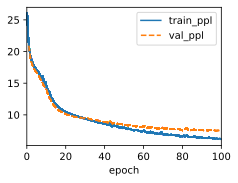

In [19]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Decoding

Once a language model has been learned,
we can use it not only to predict the next token
but to continue predicting each subsequent one,
treating the previously predicted token as though
it were the next in the input.
Sometimes we will just want to generate text
as though we were starting at the beginning
of a document.
However, it is often useful to condition
the language model on a user-supplied prefix.
For example, if we were developing an
autocomplete feature for a search engine
or to assist users in writing emails,
we would want to feed in what they
had written so far (the prefix),
and then generate a likely continuation.


[**The following `predict` method
generates a continuation, one character at a time,
after ingesting a user-provided `prefix`**].
When looping through the characters in `prefix`,
we keep passing the hidden state
to the next time step
but do not generate any output.
This is called the *warm-up* period.
After ingesting the prefix, we are now
ready to begin emitting the subsequent characters,
each of which will be fed back into the model
as the input at the next time step.


In [20]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In the following, we specify the prefix
and have it generate 20 additional characters.


In [21]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has i and the that the '

While implementing the above RNN model from scratch is instructive, it is not convenient.
In the next section, we will see how to leverage deep learning frameworks to whip up RNNs
using standard architectures, and to reap performance gains
by relying on highly optimized library functions.


## Summary

We can train RNN-based language models to generate text following the user-provided text prefix.
A simple RNN language model consists of input encoding, RNN modeling, and output generation.
During training, gradient clipping can mitigate the problem of exploding gradients but does not address the problem of vanishing gradients. In the experiment, we implemented a simple RNN language model and trained it with gradient clipping on sequences of text, tokenized at the character level. By conditioning on a prefix, we can use a language model to generate likely continuations, which proves useful in many applications, e.g., autocomplete features.


## Exercises

1. Does the implemented language model predict the next token based on all the past tokens up to the very first token in *The Time Machine*?
1. Which hyperparameter controls the length of history used for prediction?
1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
1. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity. How low can you go while sticking with this simple architecture?
1. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?
1. Conduct an experiment to determine how well this language model
   trained on *The Time Machine* works on other books by H. G. Wells,
   e.g., *The War of the Worlds*.
1. Conduct another experiment to evaluate the perplexity of this model
   on books written by other authors.
1. Modify the prediction method so as to use sampling
   rather than picking the most likely next character.
    * What happens?
    * Bias the model towards more likely outputs, e.g.,
    by sampling from $q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$ for $\alpha > 1$.
1. Run the code in this section without clipping the gradient. What happens?
1. Replace the activation function used in this section with ReLU
   and repeat the experiments in this section. Do we still need gradient clipping? Why?


Answer:
1. No, the implemented language model does not predict the next token based on all tokens up to the very first one in *The Time Machine*. The model only uses a fixed-length window of past tokens (a truncated history) rather than the entire sequence, which helps reduce memory and computation requirements.

2. The hyperparameter that controls the length of history used for prediction is the number of time steps in a minibatch. This parameter determines how many tokens from the past the model considers when making predictions for the next token.

3.  One-hot encoding is equivalent to picking a different embedding for each object because it assigns a unique vector to each object in the vocabulary. In one-hot encoding, each vector has a single 1 at the index corresponding to the object and 0s elsewhere. This is mathematically similar to using distinct learnable embeddings where each object has a unique vector in the embedding space, although in one-hot encoding, the vectors are fixed and non-learnable.

4.  To improve the perplexity of the model, we can adjust the number of epochs, hidden units, time steps, and learning rate. Increasing the number of epochs allows the model to train for longer, capturing more patterns in the data. Increasing hidden units enhances the model's capacity to learn complex relationships. Adjusting the number of time steps can help capture more context, and tuning the learning rate affects how fast the model converges. With careful tuning, we can reduce perplexity, though the architecture's simplicity will limit how low perplexity can go.

5. Replacing one-hot encoding with learnable embeddings often leads to better performance. Learnable embeddings allow the model to capture semantic similarities between tokens, improving generalization and reducing perplexity compared to one-hot vectors, which treat each token as completely distinct from others.

6. Training the model on *The Time Machine* and testing it on another H. G. Wells book like *The War of the Worlds* would show how well the model generalizes within the same author's style and vocabulary. Results may vary depending on the similarity between the two books' vocabularies and writing styles. If they are similar, the model should perform reasonably well, though some loss in performance is expected.

7. When evaluating the model on books by other authors, we would likely observe a higher perplexity. Differences in vocabulary, sentence structure, and writing style across authors will challenge the model, which was trained on a specific set of language patterns from *The Time Machine*. This experiment would highlight the limitations of domain-specific training.

8. Modifying the prediction method to use sampling rather than selecting the most likely next character introduces more variety in the model's output, making it less deterministic. Sampling based on a probability distribution biased by a factor \( \alpha \) (where \( \alpha > 1 \)) would make the model favor more probable outputs even more. This could lead to more coherent predictions in some cases but might also reduce diversity in the generated text.

9. Running the code without gradient clipping would likely result in exploding gradients, especially in RNNs when backpropagating through long sequences. This would cause the model to become unstable, leading to large weight updates and potentially causing the training process to fail or result in poor performance.

10. Replacing the activation function with ReLU and repeating the experiments may reduce the vanishing gradient problem but could still require gradient clipping. ReLU activation avoids gradient saturation, helping the model learn more efficiently, but if the gradients become too large (exploding gradients), clipping would still be necessary to prevent instability during training.

9.6

# Concise Implementation of Recurrent Neural Networks
:label:`sec_rnn-concise`

Like most of our from-scratch implementations,
:numref:`sec_rnn-scratch` was designed
to provide insight into how each component works.
But when you are using RNNs every day
or writing production code,
you will want to rely more on libraries
that cut down on both implementation time
(by supplying library code for common models and functions)
and computation time
(by optimizing the heck out of these library implementations).
This section will show you how to implement
the same language model more efficiently
using the high-level API provided
by your deep learning framework.
We begin, as before, by loading
*The Time Machine* dataset.


In [22]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## [**Defining the Model**]

We define the following class
using the RNN implemented
by high-level APIs.


In [23]:
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

Inheriting from the `RNNLMScratch` class in :numref:`sec_rnn-scratch`,
the following `RNNLM` class defines a complete RNN-based language model.
Note that we need to create a separate fully connected output layer.


In [24]:
class RNNLM(d2l.RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

## Training and Predicting

Before training the model, let's [**make a prediction
with a model initialized with random weights.**]
Given that we have not trained the network,
it will generate nonsensical predictions.


In [25]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it haslclclclclclclclclclc'

Next, we [**train our model, leveraging the high-level API**].


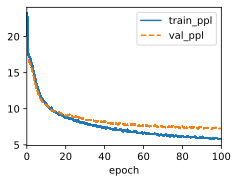

In [26]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Compared with :numref:`sec_rnn-scratch`,
this model achieves comparable perplexity,
but runs faster due to the optimized implementations.
As before, we can generate predicted tokens
following the specified prefix string.


In [27]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the time travell'

## Summary

High-level APIs in deep learning frameworks provide implementations of standard RNNs.
These libraries help you to avoid wasting time reimplementing standard models.
Moreover,
framework implementations are often highly optimized,
  leading to significant (computational) performance gains
  when compared with implementations from scratch.

## Exercises

1. Can you make the RNN model overfit using the high-level APIs?
1. Implement the autoregressive model of :numref:`sec_sequence` using an RNN.


Answer:
1. Yes, it is possible to make an RNN model overfit using high-level APIs. Overfitting happens when the model learns to memorize the training data rather than generalizing from it. In high-level APIs such as PyTorch or TensorFlow, we can induce overfitting by using a small training dataset, too many epochs, an excessive number of hidden units in the model, or insufficient regularization (e.g., no dropout or L2 regularization). These conditions allow the model to fit the training data perfectly, but it will likely perform poorly on unseen data, which is the hallmark of overfitting.

2.  To implement an autoregressive model with an RNN, we can follow this approach:

```python
import torch
import torch.nn as nn
import torch.optim as optim

class RNN_AutoregressiveModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNN_AutoregressiveModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # Embed the input characters
        x = self.embedding(x)
        # Pass the embeddings through the RNN
        out, hidden = self.rnn(x, hidden)
        # Decode the output from the RNN to predict the next token
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state
        return torch.zeros(num_layers, batch_size, hidden_size)

# Hyperparameters
vocab_size = 10000  # Example vocabulary size
embed_size = 128  # Embedding size
hidden_size = 256  # Number of hidden units in the RNN
num_layers = 2  # Number of RNN layers
batch_size = 64
seq_length = 30  # Sequence length
num_epochs = 10
learning_rate = 0.001

# Define the model
model = RNN_AutoregressiveModel(vocab_size, embed_size, hidden_size, num_layers)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Example input and target tensors (random)
inputs = torch.randint(0, vocab_size, (batch_size, seq_length))
targets = torch.randint(0, vocab_size, (batch_size, seq_length))

# Training loop
for epoch in range(num_epochs):
    # Initialize hidden state
    hidden = model.init_hidden(batch_size)

    # Forward pass
    outputs, hidden = model(inputs, hidden)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
```

### Explanation:
- Embedding Layer: We convert input tokens (represented as indices) into dense vectors of a fixed size (`embed_size`).
- RNN Layer: The RNN processes the sequence of embeddings and maintains a hidden state that captures sequential dependencies.
- Fully Connected Layer: The RNN’s output is fed into a linear layer (`fc`) to predict the next token in the sequence.
- Training: We optimize the model using cross-entropy loss, comparing the predicted outputs with the actual targets (next tokens in the sequence).

This implementation is a basic autoregressive model using RNN for predicting the next token in a sequence, as described in the *Sequence Models* section.

9.7

# Backpropagation Through Time
:label:`sec_bptt`

If you completed the exercises in :numref:`sec_rnn-scratch`,
you would have seen that gradient clipping is vital
for preventing the occasional massive gradients
from destabilizing training.
We hinted that the exploding gradients
stem from backpropagating across long sequences.
Before introducing a slew of modern RNN architectures,
let's take a closer look at how *backpropagation*
works in sequence models in mathematical detail.
Hopefully, this discussion will bring some precision
to the notion of *vanishing* and *exploding* gradients.
If you recall our discussion of forward and backward
propagation through computational graphs
when we introduced MLPs in :numref:`sec_backprop`,
then forward propagation in RNNs
should be relatively straightforward.
Applying backpropagation in RNNs
is called *backpropagation through time* :cite:`Werbos.1990`.
This procedure requires us to expand (or unroll)
the computational graph of an RNN
one time step at a time.
The unrolled RNN is essentially
a feedforward neural network
with the special property
that the same parameters
are repeated throughout the unrolled network,
appearing at each time step.
Then, just as in any feedforward neural network,
we can apply the chain rule,
backpropagating gradients through the unrolled net.
The gradient with respect to each parameter
must be summed across all places
that the parameter occurs in the unrolled net.
Handling such weight tying should be familiar
from our chapters on convolutional neural networks.


Complications arise because sequences
can be rather long.
It is not unusual to work with text sequences
consisting of over a thousand tokens.
Note that this poses problems both from
a computational (too much memory)
and optimization (numerical instability)
standpoint.
Input from the first step passes through
over 1000 matrix products before arriving at the output,
and another 1000 matrix products
are required to compute the gradient.
We now analyze what can go wrong and
how to address it in practice.


## Analysis of Gradients in RNNs
:label:`subsec_bptt_analysis`

We start with a simplified model of how an RNN works.
This model ignores details about the specifics
of the hidden state and how it is updated.
The mathematical notation here
does not explicitly distinguish
scalars, vectors, and matrices.
We are just trying to develop some intuition.
In this simplified model,
we denote $h_t$ as the hidden state,
$x_t$ as input, and $o_t$ as output
at time step $t$.
Recall our discussions in
:numref:`subsec_rnn_w_hidden_states`
that the input and the hidden state
can be concatenated before being multiplied
by one weight variable in the hidden layer.
Thus, we use $w_\textrm{h}$ and $w_\textrm{o}$ to indicate the weights
of the hidden layer and the output layer, respectively.
As a result, the hidden states and outputs
at each time step are

$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_\textrm{h}),\\o_t &= g(h_t, w_\textrm{o}),\end{aligned}$$
:eqlabel:`eq_bptt_ht_ot`

where $f$ and $g$ are transformations
of the hidden layer and the output layer, respectively.
Hence, we have a chain of values
$\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$
that depend on each other via recurrent computation.
The forward propagation is fairly straightforward.
All we need is to loop through the $(x_t, h_t, o_t)$ triples one time step at a time.
The discrepancy between output $o_t$ and the desired target $y_t$
is then evaluated by an objective function
across all the $T$ time steps as

$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_\textrm{h}, w_\textrm{o}) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$



For backpropagation, matters are a bit trickier,
especially when we compute the gradients
with regard to the parameters $w_\textrm{h}$ of the objective function $L$.
To be specific, by the chain rule,

$$\begin{aligned}\frac{\partial L}{\partial w_\textrm{h}}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_\textrm{h}}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_\textrm{o})}{\partial h_t}  \frac{\partial h_t}{\partial w_\textrm{h}}.\end{aligned}$$
:eqlabel:`eq_bptt_partial_L_wh`

The first and the second factors of the
product in :eqref:`eq_bptt_partial_L_wh`
are easy to compute.
The third factor $\partial h_t/\partial w_\textrm{h}$ is where things get tricky,
since we need to recurrently compute the effect of the parameter $w_\textrm{h}$ on $h_t$.
According to the recurrent computation
in :eqref:`eq_bptt_ht_ot`,
$h_t$ depends on both $h_{t-1}$ and $w_\textrm{h}$,
where computation of $h_{t-1}$
also depends on $w_\textrm{h}$.
Thus, evaluating the total derivate of $h_t$
with respect to $w_\textrm{h}$ using the chain rule yields

$$\frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_recur`


To derive the above gradient, assume that we have
three sequences $\{a_{t}\},\{b_{t}\},\{c_{t}\}$
satisfying $a_{0}=0$ and $a_{t}=b_{t}+c_{t}a_{t-1}$ for $t=1, 2,\ldots$.
Then for $t\geq 1$, it is easy to show

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$
:eqlabel:`eq_bptt_at`

By substituting $a_t$, $b_t$, and $c_t$ according to

$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_\textrm{h}},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}},\end{aligned}$$

the gradient computation in :eqref:`eq_bptt_partial_ht_wh_recur` satisfies
$a_{t}=b_{t}+c_{t}a_{t-1}$.
Thus, per :eqref:`eq_bptt_at`,
we can remove the recurrent computation
in :eqref:`eq_bptt_partial_ht_wh_recur` with

$$\frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_gen`

While we can use the chain rule to compute $\partial h_t/\partial w_\textrm{h}$ recursively,
this chain can get very long whenever $t$ is large.
Let's discuss a number of strategies for dealing with this problem.

### Full Computation ###

One idea might be to compute the full sum in :eqref:`eq_bptt_partial_ht_wh_gen`.
However, this is very slow and gradients can blow up,
since subtle changes in the initial conditions
can potentially affect the outcome a lot.
That is, we could see things similar to the butterfly effect,
where minimal changes in the initial conditions
lead to disproportionate changes in the outcome.
This is generally undesirable.
After all, we are looking for robust estimators that generalize well.
Hence this strategy is almost never used in practice.

### Truncating Time Steps###

Alternatively,
we can truncate the sum in
:eqref:`eq_bptt_partial_ht_wh_gen`
after $\tau$ steps.
This is what we have been discussing so far.
This leads to an *approximation* of the true gradient,
simply by terminating the sum at $\partial h_{t-\tau}/\partial w_\textrm{h}$.
In practice this works quite well.
It is what is commonly referred to as truncated
backpropgation through time :cite:`Jaeger.2002`.
One of the consequences of this is that the model
focuses primarily on short-term influence
rather than long-term consequences.
This is actually *desirable*, since it biases the estimate
towards simpler and more stable models.


### Randomized Truncation ###

Last, we can replace $\partial h_t/\partial w_\textrm{h}$
by a random variable which is correct in expectation
but truncates the sequence.
This is achieved by using a sequence of $\xi_t$
with predefined $0 \leq \pi_t \leq 1$,
where $P(\xi_t = 0) = 1-\pi_t$ and
$P(\xi_t = \pi_t^{-1}) = \pi_t$, thus $E[\xi_t] = 1$.
We use this to replace the gradient
$\partial h_t/\partial w_\textrm{h}$
in :eqref:`eq_bptt_partial_ht_wh_recur`
with

$$z_t= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$


It follows from the definition of $\xi_t$
that $E[z_t] = \partial h_t/\partial w_\textrm{h}$.
Whenever $\xi_t = 0$ the recurrent computation
terminates at that time step $t$.
This leads to a weighted sum of sequences of varying lengths,
where long sequences are rare but appropriately overweighted.
This idea was proposed by
:citet:`Tallec.Ollivier.2017`.

### Comparing Strategies

![Comparing strategies for computing gradients in RNNs. From top to bottom: randomized truncation, regular truncation, and full computation.](../img/truncated-bptt.svg)
:label:`fig_truncated_bptt`


:numref:`fig_truncated_bptt` illustrates the three strategies
when analyzing the first few characters of *The Time Machine*
using backpropagation through time for RNNs:

* The first row is the randomized truncation that partitions the text into segments of varying lengths.
* The second row is the regular truncation that breaks the text into subsequences of the same length. This is what we have been doing in RNN experiments.
* The third row is the full backpropagation through time that leads to a computationally infeasible expression.


Unfortunately, while appealing in theory,
randomized truncation does not work
much better than regular truncation,
most likely due to a number of factors.
First, the effect of an observation
after a number of backpropagation steps
into the past is quite sufficient
to capture dependencies in practice.
Second, the increased variance counteracts the fact
that the gradient is more accurate with more steps.
Third, we actually *want* models that have only
a short range of interactions.
Hence, regularly truncated backpropagation through time
has a slight regularizing effect that can be desirable.

## Backpropagation Through Time in Detail

After discussing the general principle,
let's discuss backpropagation through time in detail.
In contrast to the analysis in :numref:`subsec_bptt_analysis`,
in the following we will show how to compute
the gradients of the objective function
with respect to all the decomposed model parameters.
To keep things simple, we consider
an RNN without bias parameters,
whose activation function in the hidden layer
uses the identity mapping ($\phi(x)=x$).
For time step $t$, let the single example input
and the target be $\mathbf{x}_t \in \mathbb{R}^d$ and $y_t$, respectively.
The hidden state $\mathbf{h}_t \in \mathbb{R}^h$
and the output $\mathbf{o}_t \in \mathbb{R}^q$
are computed as

$$\begin{aligned}\mathbf{h}_t &= \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_\textrm{qh} \mathbf{h}_{t},\end{aligned}$$

where $\mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$, $\mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$, and
$\mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$
are the weight parameters.
Denote by $l(\mathbf{o}_t, y_t)$
the loss at time step $t$.
Our objective function,
the loss over $T$ time steps
from the beginning of the sequence is thus

$$L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, y_t).$$


In order to visualize the dependencies among
model variables and parameters during computation
of the RNN,
we can draw a computational graph for the model,
as shown in :numref:`fig_rnn_bptt`.
For example, the computation of the hidden states of time step 3,
$\mathbf{h}_3$, depends on the model parameters
$\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$,
the hidden state of the previous time step $\mathbf{h}_2$,
and the input of the current time step $\mathbf{x}_3$.

![Computational graph showing dependencies for an RNN model with three time steps. Boxes represent variables (not shaded) or parameters (shaded) and circles represent operators.](../img/rnn-bptt.svg)
:label:`fig_rnn_bptt`

As just mentioned, the model parameters in :numref:`fig_rnn_bptt`
are $\mathbf{W}_\textrm{hx}$, $\mathbf{W}_\textrm{hh}$, and $\mathbf{W}_\textrm{qh}$.
Generally, training this model requires
gradient computation with respect to these parameters
$\partial L/\partial \mathbf{W}_\textrm{hx}$, $\partial L/\partial \mathbf{W}_\textrm{hh}$, and $\partial L/\partial \mathbf{W}_\textrm{qh}$.
According to the dependencies in :numref:`fig_rnn_bptt`,
we can traverse in the opposite direction of the arrows
to calculate and store the gradients in turn.
To flexibly express the multiplication of
matrices, vectors, and scalars of different shapes
in the chain rule,
we continue to use the $\textrm{prod}$ operator
as described in :numref:`sec_backprop`.


First of all, differentiating the objective function
with respect to the model output at any time step $t$
is fairly straightforward:

$$\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q.$$
:eqlabel:`eq_bptt_partial_L_ot`

Now we can calculate the gradient of the objective
with respect to the parameter $\mathbf{W}_\textrm{qh}$
in the output layer:
$\partial L/\partial \mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$.
Based on :numref:`fig_rnn_bptt`,
the objective $L$ depends on $\mathbf{W}_\textrm{qh}$
via $\mathbf{o}_1, \ldots, \mathbf{o}_T$.
Using the chain rule yields

$$
\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}}
= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_\textrm{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top,
$$

where $\partial L/\partial \mathbf{o}_t$
is given by :eqref:`eq_bptt_partial_L_ot`.

Next, as shown in :numref:`fig_rnn_bptt`,
at the final time step $T$,
the objective function
$L$ depends on the hidden state $\mathbf{h}_T$
only via $\mathbf{o}_T$.
Therefore, we can easily find the gradient
$\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$
using the chain rule:

$$\frac{\partial L}{\partial \mathbf{h}_T} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}.$$
:eqlabel:`eq_bptt_partial_L_hT_final_step`

It gets trickier for any time step $t < T$,
where the objective function $L$ depends on
$\mathbf{h}_t$ via $\mathbf{h}_{t+1}$ and $\mathbf{o}_t$.
According to the chain rule,
the gradient of the hidden state
$\partial L/\partial \mathbf{h}_t \in \mathbb{R}^h$
at any time step $t < T$ can be recurrently computed as:


$$\frac{\partial L}{\partial \mathbf{h}_t} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}.$$
:eqlabel:`eq_bptt_partial_L_ht_recur`

For analysis, expanding the recurrent computation
for any time step $1 \leq t \leq T$ gives

$$\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}.$$
:eqlabel:`eq_bptt_partial_L_ht`

We can see from :eqref:`eq_bptt_partial_L_ht`
that this simple linear example already
exhibits some key problems of long sequence models:
it involves potentially very large powers of $\mathbf{W}_\textrm{hh}^\top$.
In it, eigenvalues smaller than 1 vanish
and eigenvalues larger than 1 diverge.
This is numerically unstable,
which manifests itself in the form of vanishing
and exploding gradients.
One way to address this is to truncate the time steps
at a computationally convenient size
as discussed in :numref:`subsec_bptt_analysis`.
In practice, this truncation can also be effected
by detaching the gradient after a given number of time steps.
Later on, we will see how more sophisticated sequence models
such as long short-term memory can alleviate this further.

Finally, :numref:`fig_rnn_bptt` shows
that the objective function $L$
depends on model parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$
in the hidden layer via hidden states
$\mathbf{h}_1, \ldots, \mathbf{h}_T$.
To compute gradients with respect to such parameters
$\partial L / \partial \mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$ and $\partial L / \partial \mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$,
we apply the chain rule giving

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}
$$

where $\partial L/\partial \mathbf{h}_t$
which is recurrently computed by
:eqref:`eq_bptt_partial_L_hT_final_step`
and :eqref:`eq_bptt_partial_L_ht_recur`
is the key quantity that affects the numerical stability.



Since backpropagation through time is the application of backpropagation in RNNs,
as we have explained in :numref:`sec_backprop`,
training RNNs alternates forward propagation with
backpropagation through time.
Moreover, backpropagation through time
computes and stores the above gradients in turn.
Specifically, stored intermediate values
are reused to avoid duplicate calculations,
such as storing $\partial L/\partial \mathbf{h}_t$
to be used in computation of both $\partial L / \partial \mathbf{W}_\textrm{hx}$
and $\partial L / \partial \mathbf{W}_\textrm{hh}$.


## Summary

Backpropagation through time is merely an application of backpropagation to sequence models with a hidden state.
Truncation, such as regular or randomized, is needed for computational convenience and numerical stability.
High powers of matrices can lead to divergent or vanishing eigenvalues. This manifests itself in the form of exploding or vanishing gradients.
For efficient computation, intermediate values are cached during backpropagation through time.



## Exercises

1. Assume that we have a symmetric matrix $\mathbf{M} \in \mathbb{R}^{n \times n}$ with eigenvalues $\lambda_i$ whose corresponding eigenvectors are $\mathbf{v}_i$ ($i = 1, \ldots, n$). Without loss of generality, assume that they are ordered in the order $|\lambda_i| \geq |\lambda_{i+1}|$.
   1. Show that $\mathbf{M}^k$ has eigenvalues $\lambda_i^k$.
   1. Prove that for a random vector $\mathbf{x} \in \mathbb{R}^n$, with high probability $\mathbf{M}^k \mathbf{x}$ will be very much aligned with the eigenvector $\mathbf{v}_1$
of $\mathbf{M}$. Formalize this statement.
   1. What does the above result mean for gradients in RNNs?
1. Besides gradient clipping, can you think of any other methods to cope with gradient explosion in recurrent neural networks?

[Discussions](https://discuss.d2l.ai/t/334)


Answer:
1. To show that the matrix \(\mathbf{M}^k\) has eigenvalues \(\lambda_i^k\), we start by considering a symmetric matrix \(\mathbf{M} \in \mathbb{R}^{n \times n}\) with eigenvalues \(\lambda_i\) and corresponding eigenvectors \(\mathbf{v}_i\). By definition, if \(\mathbf{M} \mathbf{v}_i = \lambda_i \mathbf{v}_i\), applying the matrix \(\mathbf{M}\) repeatedly leads to \(\mathbf{M}^2 \mathbf{v}_i = \mathbf{M}(\lambda_i \mathbf{v}_i) = \lambda_i \mathbf{M} \mathbf{v}_i = \lambda_i^2 \mathbf{v}_i\). This reasoning can be extended by induction to show that for any positive integer \(k\), \(\mathbf{M}^k \mathbf{v}_i = \lambda_i^k \mathbf{v}_i\). Thus, the eigenvalues of \(\mathbf{M}^k\) are indeed \(\lambda_i^k\).

For a random vector \(\mathbf{x} \in \mathbb{R}^n\), as \(k\) increases, the vector \(\mathbf{M}^k \mathbf{x}\) aligns increasingly with the principal eigenvector \(\mathbf{v}_1\), which corresponds to the largest eigenvalue \(\lambda_1\). This can be formalized by stating that the alignment metric, given by \(\frac{|\langle \mathbf{M}^k \mathbf{x}, \mathbf{v}_1 \rangle|}{\|\mathbf{M}^k \mathbf{x}\| \|\mathbf{v}_1\|}\), approaches 1 with high probability as \(k\) tends to infinity. In essence, this implies that, as the number of iterations increases, \(\mathbf{M}^k \mathbf{x}\) will predominantly reflect the direction of \(\mathbf{v}_1\), causing contributions from other eigenvectors to diminish significantly.

The results above imply significant consequences for gradients in recurrent neural networks (RNNs). As the iterations progress, the gradients associated with the loss function will increasingly align with the principal eigenvector corresponding to the largest eigenvalue. If this largest eigenvalue is less than 1, it can lead to vanishing gradients, causing learning to stagnate since updates become negligible. Conversely, if the eigenvalue is significantly greater than 1, it may result in exploding gradients, where the gradients grow excessively and destabilize training. This understanding highlights the importance of carefully managing the eigenvalues of weight matrices in RNNs to ensure effective training.

2.  In addition to gradient clipping, several alternative methods can be employed to address gradient explosion in recurrent neural networks (RNNs). One effective approach is weight regularization, specifically L2 regularization, which penalizes large weight values and can help maintain more stable gradients. Another strategy involves using gradient noise injection, where noise is added to the gradient updates to promote robustness during training, thereby mitigating the effects of large gradients. Layer normalization is also beneficial, as it normalizes the inputs across features within a layer, providing additional stability and preventing extreme gradient magnitudes. Furthermore, adaptive learning rate optimizers, such as Adam or RMSprop, adjust the learning rates based on the history of gradients, allowing for more controlled updates and reducing the risk of gradient explosion. Additionally, employing architectures like Long Short-Term Memory (LSTM) networks or Gated Recurrent Units (GRUs) can help manage gradient flow due to their inherent gating mechanisms, making them more resilient to issues of exploding and vanishing gradients. By integrating these methods, the training of RNNs can be made more stable and effective.